In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import os
import torch
import numpy as np
import scipy
import h5py

In [13]:
from src.utils.logger import Logging
from src.utils.plotting_regular_2D_time_seqeunce import draw_contourf_regular_2D

from src.nn.tanh import MLP
from src.nn.tanh2 import MLP2
from src.nn.kan2 import KAN2
from src.utils.plot_losses import plot_M1_loss_history

DEVICE = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# file_path = "/home/vlq26735/saiful/afrah/datasets/IBM/IB_PINN3.mat"

# h=  0.498715
# k=  0.6851750000000001
# rx=  0.209685
# ry=  0.21008499999999997

In [14]:
TEST_CHECKPOINT_PATH = "./checkpoints"
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

logger.print(f"Device used {DEVICE}")

INFO:src.utils.logger:Device used cpu


### Load  and reshape the Testing Dataset if required

In [15]:
processed_dataset_path = "./data/Fluid_trainingData.mat"
Fluid_data = scipy.io.loadmat(processed_dataset_path)
data = h5py.File("data/IB_PINN3.mat", "r")  # load dataset from matlab
fluid = np.transpose(
    data["Fluid"], axes=range(len(data.get("Fluid").shape) - 1, -1, -1)
).astype(np.float32)

interface = Fluid_data["Solid_interface"]
solid = Fluid_data["Solid_points"]


In [16]:
tstep = 101
xstep = 102
ystep = 102

part = "Fluid"
N_data = xstep * ystep

steps = [tstep, xstep, ystep]
txy = [fluid[:, 0], fluid[:, 1], fluid[:, 2]]


input_interface = np.concatenate(
    [interface[:, 0:1], interface[:, 1:2], interface[:, 2:3]], axis=1
)


final loss BC: 4.88e-03
final loss Data: 6.90e-03
final loss FSI: 1.05e-02
final loss Initial: 5.68e-04
final loss Total: 4.38e-02


/home/vlq26735/saiful/afrah/code/pinn_ibm4fsi2/src/utils/plot_losses.py:139: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=y_min)


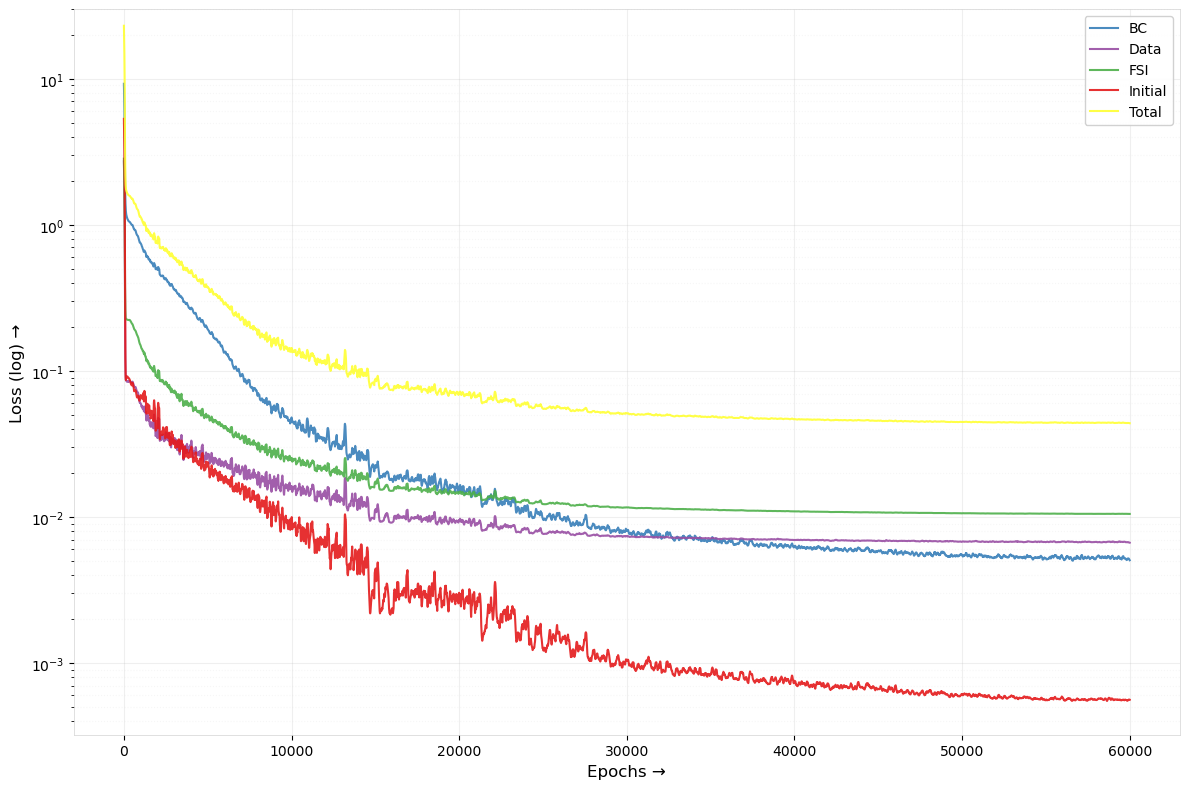

final loss BC: 2.32e-04
final loss Data: 6.18e-04
final loss FSI: 4.21e-04
final loss Initial: 1.60e-05
final loss Total: 4.36e-03


/home/vlq26735/saiful/afrah/code/pinn_ibm4fsi2/src/utils/plot_losses.py:139: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=y_min)


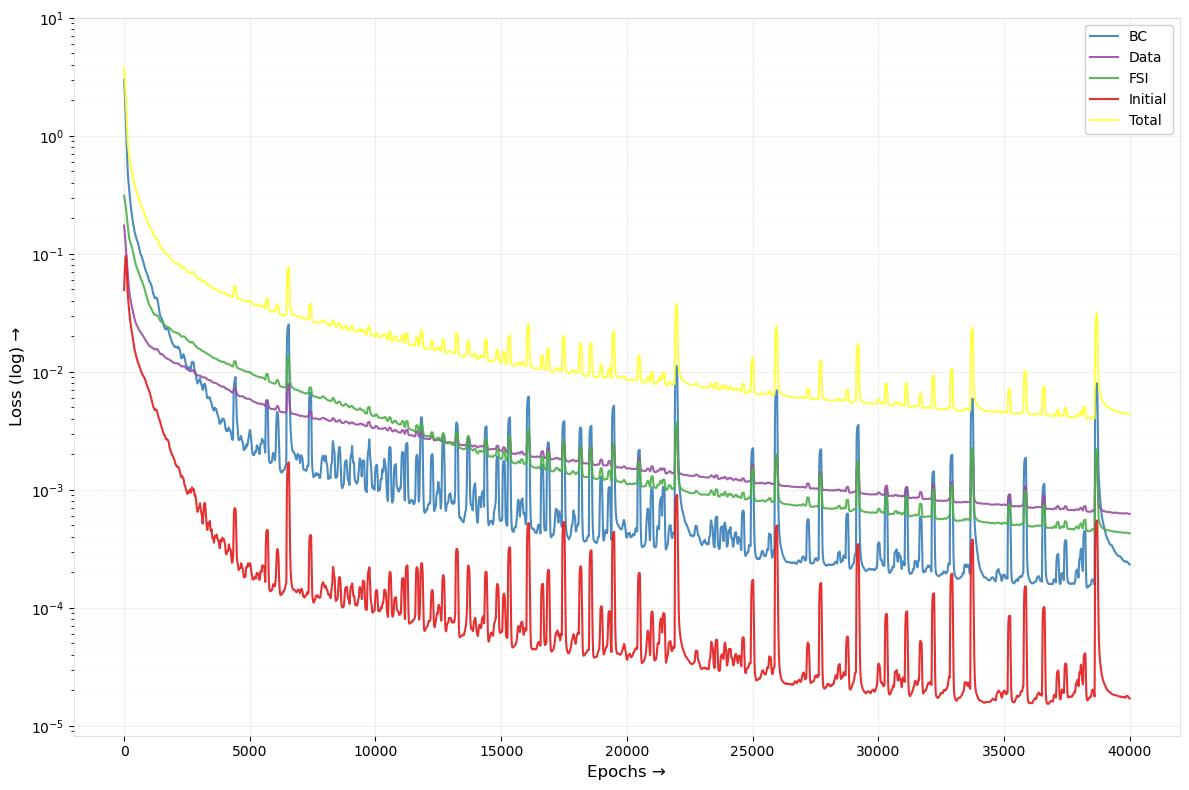

KAN2(
  (shared_layers): ModuleList(
    (0-1): 2 x KANLinear(
      (base_activation): SiLU()
    )
  )
  (velocity_branch): Sequential(
    (0): KANLinear(
      (base_activation): SiLU()
    )
    (1): KANLinear(
      (base_activation): SiLU()
    )
  )
  (pressure_branch): Sequential(
    (0): KANLinear(
      (base_activation): SiLU()
    )
    (1): KANLinear(
      (base_activation): SiLU()
    )
    (2): KANLinear(
      (base_activation): SiLU()
    )
  )
)

In [17]:
# m1_path = "./checkpoints/2025-05-02_20-18-03-014736/model.pth"
m1_path = "./checkpoints/2025-05-04_07-55-25-536831/model.pth"
m2_path = "./checkpoints/2025-05-02_20-01-28-664593/model.pth"  ## kan model

model_state_m1 = torch.load(m1_path)
model_state_m2 = torch.load(m2_path)

solver_m1 = model_state_m1["solver"]
solver_m2 = model_state_m2["solver"]

if solver_m1 == "mlp":
    fluid_model_m1 = MLP2(model_state_m1["fluid_network"]).to("cpu")
else:
    fluid_model_m1 = KAN2(model_state_m1["fluid_network"]).to("cpu")

if solver_m2 == "mlp":
    fluid_model_m2 = MLP2(model_state_m2["fluid_network"]).to("cpu")
    # solid_model_m2 = MLP2(model_state_m2["solid_network"]).to("cpu")
else:
    fluid_model_m2 = KAN2(model_state_m2["fluid_network"]).to("cpu")
    # solid_model_m2 = KAN(model_state_m2["solid_network"]).to("cpu")

plot_M1_loss_history(
    model_state_m1["loss_history"],
    os.path.join(logger.get_output_dir(), "loss_history_M1.png"),
    y_max=30,
    y_min=0,
    figsize=(12, 8),
)

plot_M1_loss_history(
    model_state_m2["loss_history"],
    os.path.join(logger.get_output_dir(), "loss_history_M2.png"),
    y_max=10,
    y_min=0,
    figsize=(12, 8),
)

fluid_model_m1.load_state_dict(model_state_m1["fluid_model_state_dict"])
fluid_model_m2.load_state_dict(model_state_m2["fluid_model_state_dict"])

# if solid_model_m2 is not None:
#     solid_model_m2.load_state_dict(model_state_m2["solid_model_state_dict"])
#     solid_model_m2.eval()

fluid_model_m1.eval()
fluid_model_m2.eval()

In [18]:
with torch.no_grad():
    outputs_fluid_m1 = np.array(
        fluid_model_m1(
            torch.cat(
                [
                    torch.tensor(fluid[:, 0:1], dtype=torch.float32),
                    torch.tensor(fluid[:, 1:2], dtype=torch.float32),
                    torch.tensor(fluid[:, 2:3], dtype=torch.float32),
                ],
                dim=1,
            ).squeeze(1)
        )
    )
    outputs_interface_m1 = np.array(
        fluid_model_m1(
            torch.cat(
                [
                    torch.tensor(interface[:, 0:1], dtype=torch.float32),
                    torch.tensor(interface[:, 1:2], dtype=torch.float32),
                    torch.tensor(interface[:, 2:3], dtype=torch.float32),
                ],
                dim=1,
            ).squeeze(1)
        )
    )
    outputs_fluid_m2 = np.array(
        fluid_model_m2(
            torch.cat(
                [
                    torch.tensor(fluid[:, 0:1], dtype=torch.float32),
                    torch.tensor(fluid[:, 1:2], dtype=torch.float32),
                    torch.tensor(fluid[:, 2:3], dtype=torch.float32),
                ],
                dim=1,
            ).squeeze(1)
        )
    )
    outputs_interface_m2 = np.array(
        fluid_model_m2(
            torch.cat(
                [
                    torch.tensor(interface[:, 0:1], dtype=torch.float32),
                    torch.tensor(interface[:, 1:2], dtype=torch.float32),
                    torch.tensor(interface[:, 2:3], dtype=torch.float32),
                ],
                dim=1,
            ).squeeze(1)
        )
    )

u_pred_fluid_m1 = outputs_fluid_m1[:, 0:1]
v_pred_fluid_m1 = outputs_fluid_m1[:, 1:2]
p_pred_fluid_m1 = outputs_fluid_m1[:, 2:3]
u_pred_interface_m1 = outputs_interface_m1[:, 0:1]
v_pred_interface_m1 = outputs_interface_m1[:, 1:2]
p_pred_interface_m1 = outputs_interface_m1[:, 2:3]

u_pred_fluid_m2 = outputs_fluid_m2[:, 0:1]
v_pred_fluid_m2 = outputs_fluid_m2[:, 1:2]
p_pred_fluid_m2 = outputs_fluid_m2[:, 2:3]
u_pred_interface_m2 = outputs_interface_m2[:, 0:1]
v_pred_interface_m2 = outputs_interface_m2[:, 1:2]
p_pred_interface_m2 = outputs_interface_m2[:, 2:3]


In [19]:
rel_u_l2_error = (
    np.sqrt(
        np.mean((u_pred_fluid_m1 - np.array(fluid[:, 3:4])) ** 2)
        / np.mean(np.array(fluid[:, 3:4]) ** 2)
    )
    * 100
)
rel_v_l2_error = (
    np.sqrt(
        np.mean((v_pred_fluid_m1 - np.array(fluid[:, 4:5])) ** 2)
        / np.mean(np.array(fluid[:, 4:5]) ** 2)
    )
    * 100
)
rel_p_l2_error = (
    np.sqrt(
        np.mean((p_pred_fluid_m1 - np.array(fluid[:, 5:6])) ** 2)
        / np.mean(np.array(fluid[:, 5:6]) ** 2)
    )
    * 100
)

logger.print(f"using mode : m1")
logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")

logger.print(f"using mode : m2")

rel_u_l2_error = (
    np.sqrt(
        np.mean((u_pred_fluid_m2 - np.array(fluid[:, 3:4])) ** 2)
        / np.mean(np.array(fluid[:, 3:4]) ** 2)
    )
    * 100
)
rel_v_l2_error = (
    np.sqrt(
        np.mean((v_pred_fluid_m2 - np.array(fluid[:, 4:5])) ** 2)
        / np.mean(np.array(fluid[:, 4:5]) ** 2)
    )
    * 100
)
rel_p_l2_error = (
    np.sqrt(
        np.mean((p_pred_fluid_m2 - np.array(fluid[:, 5:6])) ** 2)
        / np.mean(np.array(fluid[:, 5:6]) ** 2)
    )
    * 100
)

logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")


## On the interface

logger.print(f"On the interface")
rel_u_l2_error = (
    np.sqrt(
        np.mean((u_pred_interface_m1 - np.array(interface[:, 3:4])) ** 2)
        / np.mean(np.array(interface[:, 3:4]) ** 2)
    )
    * 100
)
rel_v_l2_error = (
    np.sqrt(
        np.mean((v_pred_interface_m1 - np.array(interface[:, 4:5])) ** 2)
        / np.mean(np.array(interface[:, 4:5]) ** 2)
    )
    * 100
)
rel_p_l2_error = (
    np.sqrt(
        np.mean((p_pred_interface_m1 - np.array(interface[:, 5:6])) ** 2)
        / np.mean(np.array(interface[:, 5:6]) ** 2)
    )
    * 100
)

logger.print(f"using mode : m1")
logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")

logger.print(f"using mode : m2")

rel_u_l2_error = (
    np.sqrt(
        np.mean((u_pred_interface_m2 - np.array(interface[:, 3:4])) ** 2)
        / np.mean(np.array(interface[:, 3:4]) ** 2)
    )
    * 100
)
rel_v_l2_error = (
    np.sqrt(
        np.mean((v_pred_interface_m2 - np.array(interface[:, 4:5])) ** 2)
        / np.mean(np.array(interface[:, 4:5]) ** 2)
    )
    * 100
)
rel_p_l2_error = (
    np.sqrt(
        np.mean((p_pred_interface_m2 - np.array(interface[:, 5:6])) ** 2)
        / np.mean(np.array(interface[:, 5:6]) ** 2)
    )
    * 100
)

logger.print(f"Relative L2 error for u: {rel_u_l2_error:.2e} %")
logger.print(f"Relative L2 error for v: {rel_v_l2_error:.2e} %")
logger.print(f"Relative L2 error for p: {rel_p_l2_error:.2e} %")


INFO:src.utils.logger:using mode : m1
INFO:src.utils.logger:Relative L2 error for u: 1.32e+01 %
INFO:src.utils.logger:Relative L2 error for v: 2.06e+01 %
INFO:src.utils.logger:Relative L2 error for p: 3.05e+01 %
INFO:src.utils.logger:using mode : m2
INFO:src.utils.logger:Relative L2 error for u: 1.14e+01 %
INFO:src.utils.logger:Relative L2 error for v: 1.71e+01 %
INFO:src.utils.logger:Relative L2 error for p: 3.44e+01 %
INFO:src.utils.logger:On the interface
INFO:src.utils.logger:using mode : m1
INFO:src.utils.logger:Relative L2 error for u: 6.01e+00 %
INFO:src.utils.logger:Relative L2 error for v: 7.08e+00 %
INFO:src.utils.logger:Relative L2 error for p: 2.93e+01 %
INFO:src.utils.logger:using mode : m2
INFO:src.utils.logger:Relative L2 error for u: 2.39e+00 %
INFO:src.utils.logger:Relative L2 error for v: 3.21e+00 %
INFO:src.utils.logger:Relative L2 error for p: 1.67e+01 %


In [20]:
# INFO:src.utils.logger:using mode : m1
# INFO:src.utils.logger:Relative L2 error for u: 1.16e+01 %
# INFO:src.utils.logger:Relative L2 error for v: 1.87e+01 %
# INFO:src.utils.logger:Relative L2 error for p: 3.87e+01 %
# INFO:src.utils.logger:using mode : m2
# INFO:src.utils.logger:Relative L2 error for u: 1.40e+01 %
# INFO:src.utils.logger:Relative L2 error for v: 2.06e+01 %
# INFO:src.utils.logger:Relative L2 error for p: 2.59e+01 %
# INFO:src.utils.logger:On the interface
# INFO:src.utils.logger:using mode : m1
# INFO:src.utils.logger:Relative L2 error for u: 5.07e+00 %
# INFO:src.utils.logger:Relative L2 error for v: 5.54e+00 %
# INFO:src.utils.logger:Relative L2 error for p: 1.75e+01 %
# INFO:src.utils.logger:using mode : m2
# INFO:src.utils.logger:Relative L2 error for u: 7.45e+00 %
# INFO:src.utils.logger:Relative L2 error for v: 8.16e+00 %
# INFO:src.utils.logger:Relative L2 error for p: 2.83e+01 %

## Draw U velocity predictions for all Models

In [21]:
#  t = tf.reshape(tstep,N_data)[:,0].T

fluid_time = np.array(fluid[:, 0:1]).reshape(tstep, xstep, ystep)[:, 0, 0]
fluid_x = np.array(fluid[:, 1:2]).reshape(tstep, xstep, ystep)[
    0, :, 0
]  # .reshape(100,100)[0,:]
fluid_y = np.array(fluid[:, 2:3]).reshape(tstep, xstep, ystep)[
    0, 0, :
]  # .reshape(100,100)[:,0]
u_fluid_cfd = np.array(fluid[:, 3]).reshape(tstep, xstep, ystep).transpose((0, 2, 1))
u_pred_fluid_m1_rshp = u_pred_fluid_m1.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
u_pred_fluid_m2_rshp = u_pred_fluid_m2.reshape(tstep, xstep, ystep).transpose((0, 2, 1))

fluid_data = [u_pred_fluid_m1_rshp] * 6 + [u_pred_fluid_m2_rshp] * 6 + [u_fluid_cfd] * 6

nrows_ncols = (3, 6)
time_steps = [0, 10, 50, 60, 80, 90] * 3
file_name = os.path.join(model_dirname, "all_models_u.png")

result = draw_contourf_regular_2D(
    fluid_time,
    fluid_x,
    fluid_y,
    fluid_data,
    nrows_ncols,
    time_steps,
    file_name,
    img_width=35,
    img_height=32,
    axes_pad=2.0,
    fontsize=20,
)

## Draw V velocity predictions for all Models

In [22]:
v_fluid_cfd = np.array(fluid[:, 4]).reshape(tstep, xstep, ystep).transpose((0, 2, 1))
v_pred_fluid_m1_rshp = v_pred_fluid_m1.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
v_pred_fluid_m2_rshp = v_pred_fluid_m2.reshape(tstep, xstep, ystep).transpose((0, 2, 1))

fluid_data = [v_pred_fluid_m1_rshp] * 6 + [v_pred_fluid_m2_rshp] * 6 + [v_fluid_cfd] * 6

grid_shape = (3, 6)
time_steps = [0, 10, 50, 60, 80, 90] * 3
file_name = os.path.join(model_dirname, "all_models_v.png")

result = draw_contourf_regular_2D(
    fluid_time,
    fluid_x,
    fluid_y,
    fluid_data,
    grid_shape,
    time_steps,
    file_name,
    img_width=35,
    img_height=32,
    axes_pad=2.0,
    fontsize=27,
)

## Pressure field prediction comparison for all models

In [23]:
p_fluid_cfd = np.array(fluid[:, 5]).reshape(tstep, xstep, ystep).transpose((0, 2, 1))
p_fluid_pred_m1_rshp = p_pred_fluid_m1.reshape(tstep, xstep, ystep).transpose((0, 2, 1))
p_fluid_pred_m2_rshp = p_pred_fluid_m2.reshape(tstep, xstep, ystep).transpose((0, 2, 1))


# Compile fluid data with replicated entries
fluid_data = [p_fluid_pred_m1_rshp] * 6 + [p_fluid_pred_m2_rshp] * 6 + [p_fluid_cfd] * 6

# Define grid shape and time steps
grid_shape = (3, 6)
time_steps = [0, 10, 50, 60, 80, 90] * 3

# Execute plotting function
file_name = os.path.join(model_dirname, "all_models_p.png")

result = draw_contourf_regular_2D(
    fluid_time,
    fluid_x,
    fluid_y,
    fluid_data,
    grid_shape,
    time_steps,
    file_name,
    img_width=35,
    img_height=32,
    axes_pad=2.0,
    fontsize=27,
)

## Animation

In [24]:
np.sqrt(u_pred_fluid_m2**2 + v_pred_fluid_m2**2).shape

(1050804, 1)

In [25]:
import os
import pandas as pd
import numpy as np
from src.utils.fsi_visualization import (
    create_frames,
    create_animations_from_existing_frames,
)

animations_pred_dir = os.path.join(logger.get_output_dir(), "animations_pred")
animations_reference_dir = os.path.join(logger.get_output_dir(), "animations_reference")
time = fluid[:, 0]
x = fluid[:, 1]
y = fluid[:, 2]
p_cfd = fluid[:, 5]
u_cfd = fluid[:, 3]
v_cfd = fluid[:, 4]

prediction_df = pd.DataFrame(
    {
        "time": time,
        "x": x,
        "y": y,
        "pressure": p_pred_fluid_m2.flatten(),
        "u_x": u_pred_fluid_m2.flatten(),
        "v_y": v_pred_fluid_m2.flatten(),
        "velocity_magnitude": np.sqrt(
            u_pred_fluid_m2**2 + v_pred_fluid_m2**2
        ).flatten(),
    }
)
reference_df = pd.DataFrame(
    {
        "time": time,
        "x": x,
        "y": y,
        "pressure": p_cfd,
        "u_x": u_cfd,
        "v_y": v_cfd,
        "velocity_magnitude": np.sqrt(u_cfd**2 + v_cfd**2),
    }
)

create_frames(prediction_df, output_dir=animations_pred_dir, sample_rate=2)

create_animations_from_existing_frames(
    frames_dirs=[
        os.path.join(animations_pred_dir, "pressure"),
        os.path.join(animations_pred_dir, "u_x"),
        os.path.join(animations_pred_dir, "v_y"),
        os.path.join(animations_pred_dir, "velocity_magnitude"),
    ],
    output_dir=os.path.join(animations_pred_dir, "gif"),
)

create_frames(reference_df, output_dir=animations_reference_dir, sample_rate=2)

create_animations_from_existing_frames(
    frames_dirs=[
        os.path.join(animations_reference_dir, "pressure"),
        os.path.join(animations_reference_dir, "u_x"),
        os.path.join(animations_reference_dir, "v_y"),
        os.path.join(animations_reference_dir, "velocity_magnitude"),
    ],
    output_dir=os.path.join(animations_reference_dir, "gif"),
)


  Processing time step 0.00 (1/51)
  Processing time step 0.02 (2/51)
  Processing time step 0.04 (3/51)
  Processing time step 0.06 (4/51)
  Processing time step 0.08 (5/51)
  Processing time step 0.10 (6/51)
  Processing time step 0.12 (7/51)
  Processing time step 0.14 (8/51)
  Processing time step 0.16 (9/51)
  Processing time step 0.18 (10/51)
  Processing time step 0.20 (11/51)
  Processing time step 0.22 (12/51)
  Processing time step 0.24 (13/51)
  Processing time step 0.26 (14/51)
  Processing time step 0.28 (15/51)
  Processing time step 0.30 (16/51)
  Processing time step 0.32 (17/51)
  Processing time step 0.34 (18/51)
  Processing time step 0.36 (19/51)
  Processing time step 0.38 (20/51)
  Processing time step 0.40 (21/51)
  Processing time step 0.42 (22/51)
  Processing time step 0.44 (23/51)
  Processing time step 0.46 (24/51)
  Processing time step 0.48 (25/51)
  Processing time step 0.50 (26/51)
  Processing time step 0.52 (27/51)
  Processing time step 0.54 (28/51)
 

## Drawing the line plot for all models

In [26]:
u_pred_fluid_m1_rshp[:, 0, :][0, :].shape

(102,)

In [27]:
u_velocity_data = {
    "u": [u_pred_fluid_m1_rshp, u_pred_fluid_m2_rshp, u_fluid_cfd],
    "v": [v_pred_fluid_m1_rshp, v_pred_fluid_m2_rshp, v_fluid_cfd],
    "p": [p_fluid_pred_m1_rshp, p_fluid_pred_m2_rshp, p_fluid_cfd],
}

models = ["M2", "M4", "Exact"]

data_labels = ["u", "v", "p"]  # Variables to plot


# Indices for time steps and y locations
timeStp = [20, 50, 65, 100]  # Indices of time values to plot
yStep = [70, 65, 90, 98]  # Indices of y values to plot

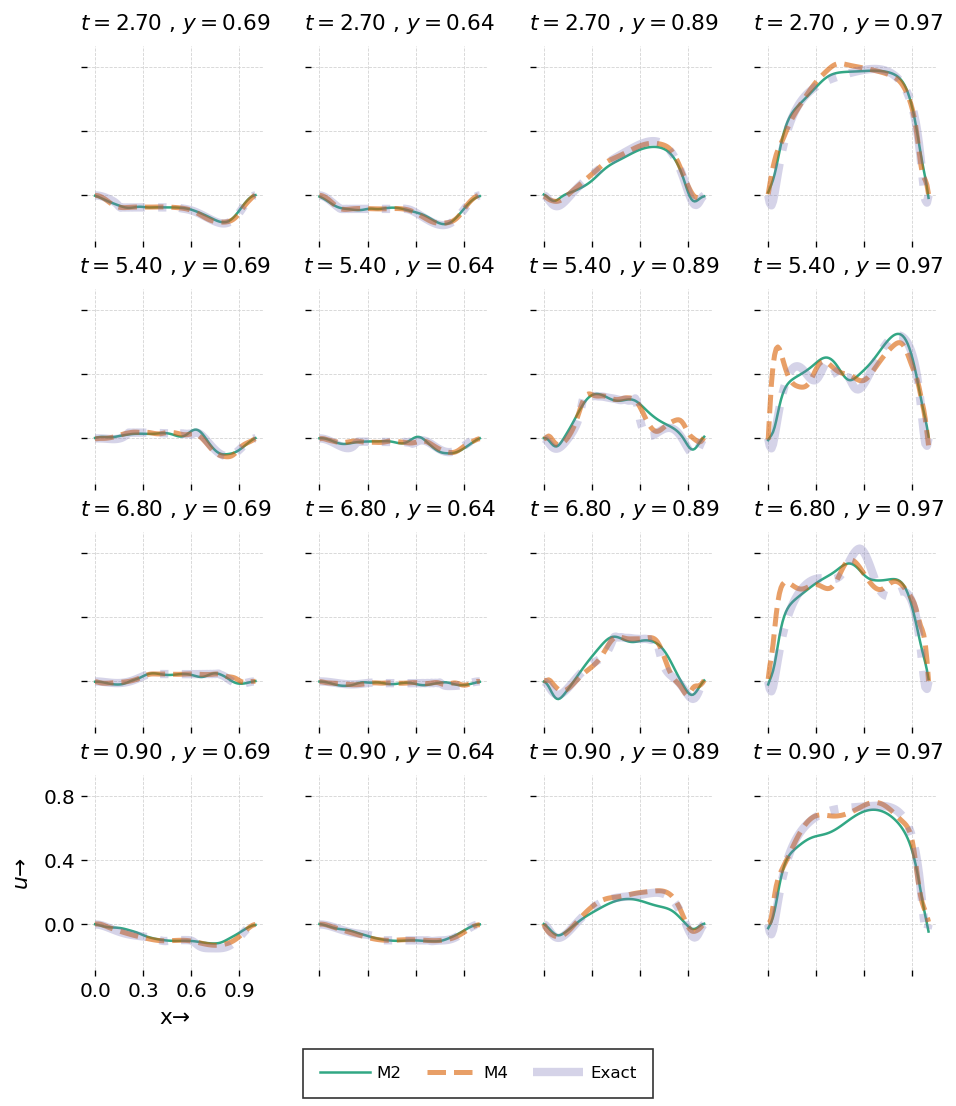

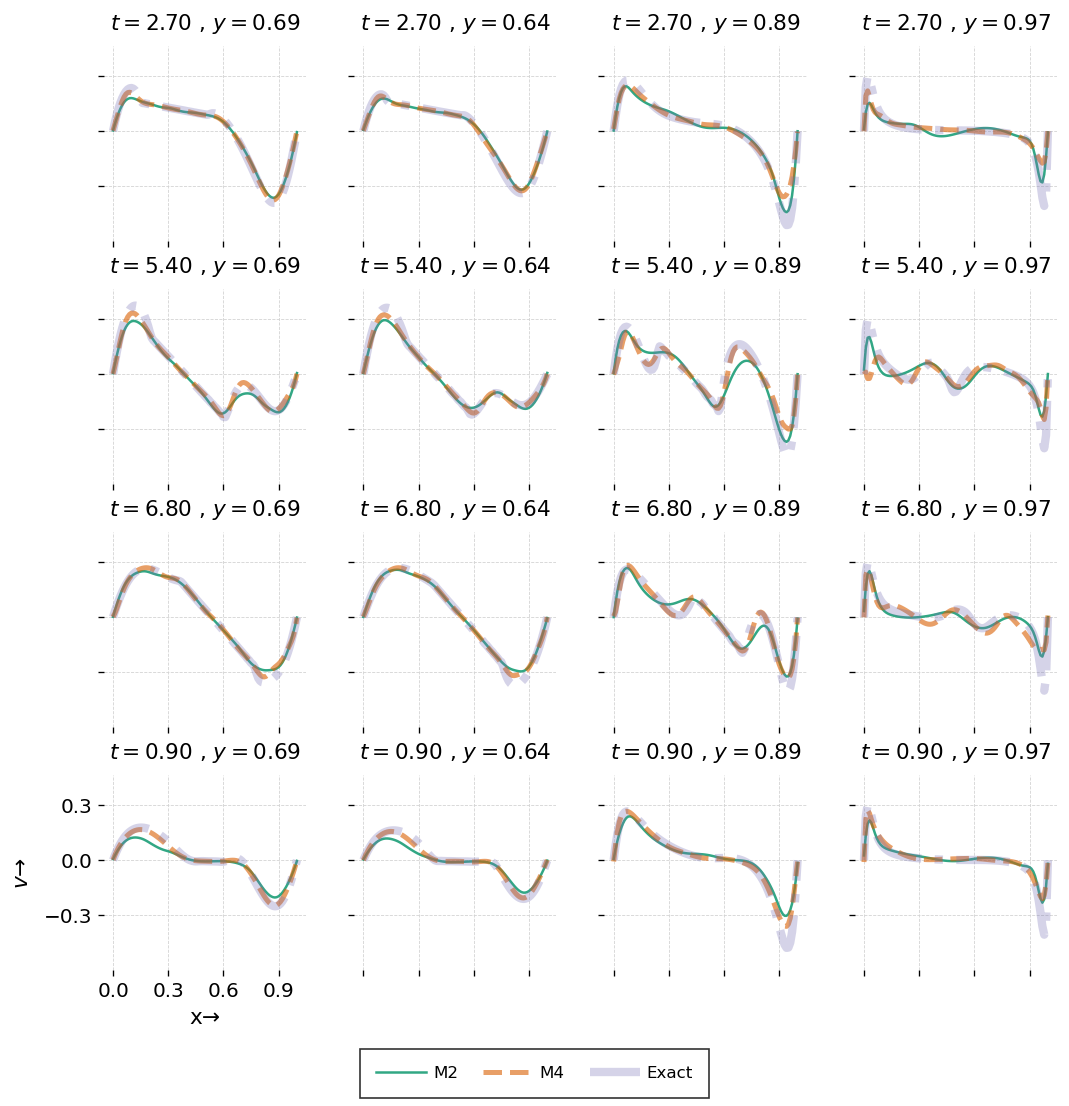

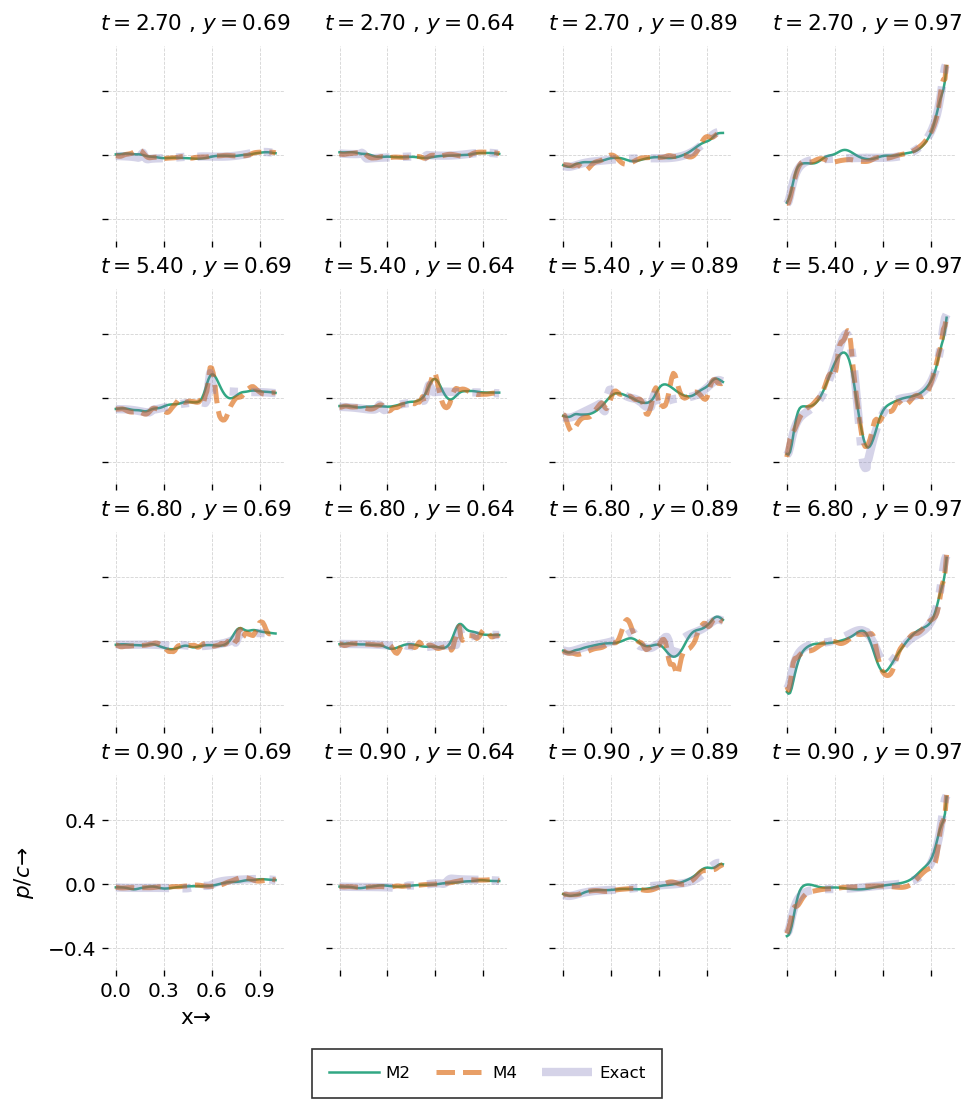

In [28]:
from src.utils.line_plot2 import enhanced_line_plot

# Call the enhanced plotting function
enhanced_line_plot(
    fluid_time,
    fluid_x,
    fluid_y,
    u_velocity_data,
    models,
    data_labels,
    timeStp,
    yStep,
    model_dirname,
    fontsize=13,
    labelsize=12,
)

In [47]:
from PIL import Image, ImageDraw, ImageFont
import os


def combine_gifs_with_titles(gif_paths, titles, output_path, grid_size=(2, 4)):
    """
    Combine multiple GIFs into a single GIF with titles in a 2-column layout.

    Args:
        gif_paths: List of paths to input GIF files
        titles: List of titles for each column
        output_path: Path for the output combined GIF
        grid_size: Tuple (cols, rows) for arranging the GIFs
    """

    # Load all GIFs and get their properties
    gifs = []
    max_frames = 0
    durations = []

    for gif_path in gif_paths:
        gif = Image.open(gif_path)
        frames = []
        gif_durations = []

        try:
            while True:
                frames.append(gif.copy())
                # Get duration for this frame (default to 100ms if not specified)
                duration = gif.info.get("duration", 100)
                gif_durations.append(duration)
                gif.seek(gif.tell() + 1)
        except EOFError:
            pass

        gifs.append((frames, gif_durations))
        max_frames = max(max_frames, len(frames))
        durations.extend(gif_durations)

    # Calculate dimensions for the combined image
    cols, rows = grid_size  # 2 columns, 4 rows (2 rows per column)

    # Get the size of the first GIF to determine cell size
    first_gif_size = gifs[0][0][0].size
    cell_width, cell_height = first_gif_size

    # Add space for column titles (increased significantly for visibility)
    title_height = 120

    # Calculate total canvas size
    canvas_width = cols * cell_width
    canvas_height = rows * cell_height + title_height  # Add title space at top

    # Use the most common duration or average duration
    avg_duration = int(sum(durations) / len(durations)) if durations else 100

    # Create combined frames
    combined_frames = []

    for frame_idx in range(max_frames):
        # Create a new frame for the combined image
        combined_frame = Image.new("RGB", (canvas_width, canvas_height), "white")
        draw = ImageDraw.Draw(combined_frame)

        # Try to load a larger font for titles with more comprehensive font paths
        font = None
        font_size = 40

        # Common font paths for different operating systems
        font_paths = ["/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"]

        # Try each font path
        for font_path in font_paths:
            try:
                font = ImageFont.truetype(font_path, font_size)
                print(f"Successfully loaded font: {font_path}")
                break
            except (IOError, OSError):
                continue

        # If no font found, create a larger version using default font approach
        if font is None:
            try:
                # Try to load default font and make it bigger by using a workaround
                font = ImageFont.load_default()
                print("Using default font - titles may be small")
            except:
                font = ImageFont.load_default()

        # Add column titles at the top
        for col_idx, title in enumerate(
            titles[:2]
        ):  # Only use first 2 titles for columns
            text_x = col_idx * cell_width + cell_width // 2

            # Get text bounding box for centering
            bbox = draw.textbbox((0, 0), title, font=font)
            text_width = bbox[2] - bbox[0]
            text_x = text_x - text_width // 2  # Center the text

            # Make text more visible by drawing it multiple times (bold effect)
            # This helps when using default font
            text_y = 5
            for offset_x in range(-1, 1):
                for offset_y in range(-1, 1):
                    draw.text(
                        (text_x, text_y),
                        title,
                        fill="black",
                        font=font,
                    )

        # Place each GIF in the grid
        # Reorganize: CFD column (velocity, pressure), PINN column (velocity, pressure)
        gif_arrangement = [
            (1, 0, 0),  # CFD velocity: row 0, col 0 (gifs[1])
            (3, 1, 0),  # CFD pressure: row 1, col 0 (gifs[3])
            (0, 0, 1),  # PINN velocity: row 0, col 1 (gifs[0])
            (2, 1, 1),  # PINN pressure: row 1, col 1 (gifs[2])
        ]

        for gif_idx, row, col in gif_arrangement:
            if gif_idx >= len(gifs):
                continue

            frames, frame_durations = gifs[gif_idx]

            # Calculate position
            x = col * cell_width
            y = row * cell_height + title_height  # Add title offset

            # Get the frame (loop if this GIF has fewer frames)
            current_frame_idx = frame_idx % len(frames)
            gif_frame = frames[current_frame_idx]

            # Resize if necessary
            if gif_frame.size != (cell_width, cell_height):
                gif_frame = gif_frame.resize(
                    (cell_width, cell_height), Image.Resampling.LANCZOS
                )

            # Paste the GIF frame
            combined_frame.paste(gif_frame, (x, y))

        combined_frames.append(combined_frame)

    # Save the combined GIF
    combined_frames[0].save(
        output_path,
        save_all=True,
        append_images=combined_frames[1:],
        duration=avg_duration,
        loop=0,  # Infinite loop
    )

    print(f"Combined GIF saved as: {output_path}")


# Define your GIF files and titles
gif_files = [
    "checkpoints/2025-05-28_17-02-26-921352/animations_pred/gif/velocity_magnitude_animation.gif",
    "checkpoints/2025-05-28_17-02-26-921352/animations_reference/gif/velocity_magnitude_animation.gif",
    "checkpoints/2025-05-28_17-02-26-921352/animations_pred/gif/pressure_animation.gif",
    "checkpoints/2025-05-28_17-02-26-921352/animations_reference/gif/pressure_animation.gif",
]

# Column titles (only 2 needed now)
column_titles = ["CFD", "PINN with B-Spline Basis Function"]

# Check if all files exist
existing_files = [f for f in gif_files if os.path.exists(f)]

if len(existing_files) == 0:
    print("No GIF files found. Please check your file paths.")
else:
    print(f"Found {len(existing_files)} GIF files")

    # Combine the GIFs with new 2-column layout
    combine_gifs_with_titles(
        gif_paths=existing_files,
        titles=column_titles,
        output_path="combined_velocity_pressure.gif",
        grid_size=(2, 2),  # 2 columns, 2 rows
    )

Found 4 GIF files
Successfully loaded font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
Successfully loaded font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
Successfully loaded font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
Successfully loaded font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
Successfully loaded font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
Successfully loaded font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
Successfully loaded font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
Successfully loaded font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
Successfully loaded font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
Successfully loaded font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
Successfully loaded font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
Successfully loaded font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
Successfully loaded font: /usr/share/fonts/truetype/dejavu/DejaVuSans.ttf
Successfully loaded 